# Preliminaries

In [1]:
#@title Install libraries
%%capture
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install vincenty

In [2]:
#@title Mount google drive
from google.colab import drive
drive.mount('/gdrive')

import os
import sys

os.chdir(r'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB')
if "." not in sys.path:
  sys.path.append(".")

Mounted at /gdrive


In [3]:
#@title GPU/CPU, RAM info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU')
else:
  print(gpu_info)

# Check GPU is available
# https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
# import tensorflow as tf
# tf.test.gpu_device_name()

# List of CPU
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


No GPU


In [4]:
#@title import libraries
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import time
import copy

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import catboost
import tensorflow as tf

# My helpers
import helpers.run_model as run_model
import helpers.tune_model as tune_model
import helpers.data_prep as data_prep

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set(color_codes=True)

# Reimport after change
import importlib
# importlib.reload(run_model)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [5]:
DATA_DIR = 'data/'
SEED_FOR_SPLIT = 0  # random_state for split

In [6]:
#@title Load dataset

#x_train = pickle.load(open(DATA_DIR + 'x_train.beforeOneHot.pickle', 'rb'))
x_train = pd.read_csv(DATA_DIR+'prepared/x_train.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
x_test = pd.read_csv(DATA_DIR+'prepared/x_test.csv.zip', compression='zip')

print('shapes: ', x_train.shape, y_train.shape)

# -- Categorical features
cat_features = ['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 
                'location of the event', 'emergency vehicle', 
                #'emergency vehicle type', 
                'vehicule_type', 'vehicule_owner',
                'rescue center', 
                'status preceding selection', 'departed from its rescue center', 
                'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday',
                'waypoint1_name', 'waypoint2_name',
                'intervention_place', # 20200420
                'waypoint3_name', 'waypoint4_name',
                ]
cat_features_idx = [i for i, name in enumerate(x_train.columns) if name in cat_features]

# -- Target variables
Y_NAMES = list(y_train.columns[1:].values)
print(Y_NAMES)
print(cat_features)
print(cat_features_idx)
# y_name by default
y_name = Y_NAMES[1]
print('y_name by default', y_name)

# -- split
x_train_sp, x_test_sp, y_train_sp, y_test_sp = train_test_split(
    x_train,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('Split dataset shapes', x_train.shape, x_test_sp.shape)

shapes:  (219337, 64) (219337, 4)
['delta selection-departure', 'delta departure-presentation', 'delta selection-presentation']
['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_owner', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday', 'waypoint1_name', 'waypoint2_name', 'intervention_place', 'waypoint3_name', 'waypoint4_name']
[0, 1, 2, 3, 4, 7, 8, 11, 13, 23, 24, 25, 26, 27, 32, 35, 38, 41, 60, 63]
y_name by default delta departure-presentation
Split dataset shapes (219337, 64) (72382, 64)


In [7]:
#@title Restrict datatset for y0
# Restricts features set
feats_4y0 = ['paris2departure_km',
            'paris2departure_bearing',
            'longitude before departure',
            'latitude before departure',
            'alert reason category',
            'alert reason',
            'intervention on public roads',
            'location of the event',
            'emergency vehicle',
            #'emergency vehicle type',
            'vehicule_type', 'vehicule_ownrer',
            'rescue center',
            'status preceding selection',
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'date key sélection',
            'time key sélection',
            'selection_weekday',
            'selection_month',
            'selection_day',
            'selection_hour',
            'selection_is_holiday',
            'time elapsed between selection and last observed GPS position', 
            'updated OSRM estimated duration',
            ]
x_train_4y0 = x_train[feats_4y0]
x_test_4y0 = x_test[feats_4y0]
cat_features_4y0 = [c for c in cat_features if c in feats_4y0]
cat_features_4y0_idx = [i for i, c in enumerate(x_train_4y0.columns) if c in cat_features_4y0]
x_train_sp_4y0, x_test_sp_4y0, y_train_sp, y_test_sp = train_test_split(
    x_train_4y0,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('cat_features_4y0:', cat_features_4y0)
print('x_train shape before/after', x_train.shape, x_train_sp_4y0.shape)

cat_features_4y0: ['alert reason category', 'alert reason', 'intervention on public roads', 'location of the event', 'emergency vehicle', 'vehicule_type', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday']
x_train shape before/after (219337, 64) (146955, 24)


## Onehot encoded data

In [8]:
x_train_1hot = pd.read_csv(DATA_DIR+'prepared/x_train_1hot.csv.zip', compression='zip')
x_test_1hot = pd.read_csv(DATA_DIR+'prepared/x_test_1hot.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')

In [9]:
Y_NAMES = list(y_train.columns[1:].values)

In [10]:
# -- split
x_train_sp_1hot, x_test_sp_1hot, y_train_sp, y_test_sp = train_test_split(
    x_train_1hot,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )

In [11]:
onehot_cols = [c for c in x_train_1hot.columns if c.startswith('H_')]
len(onehot_cols)

841

In [12]:
x_train_sp_1hot.memory_usage().sum() / 1e3

1048817.835

In [13]:
x_train_sp_1hot[onehot_cols[:4]].dtypes

H_alert reason category_2    int64
H_alert reason category_3    int64
H_alert reason category_4    int64
H_alert reason category_5    int64
dtype: object

# Models
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard<br>
https://www.kaggle.com/mgmarques/houses-prices-complete-solution

In [14]:
import datetime
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, PassiveAggressiveRegressor
import sklearn.linear_model as linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

SEED=42

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
#@title Models to run (all params by default)
models_to_run = {
    # classical
    'LinearRegression': make_pipeline(RobustScaler(), LinearRegression()),
    'Lasso': make_pipeline(RobustScaler(), Lasso()),
    'ElasticNet': make_pipeline(RobustScaler(), ElasticNet()),
    #'KernelRidge': KernelRidge(),
    
    # Trees
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=100),

    # Ensemble
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'xgboost' : xgb.XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'catboost': catboost.CatBoostRegressor(verbose=False),
    
    # SVM
    # 'SVR': SVR(),  # Too slow!
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(),
}

In [17]:
#@title dry Run
# n=1000
# m=10

# y_name = Y_NAMES[1]

# ALL_RESULTS=[]
# SAVE_RESULTS_TO_FILE = 'LOGS/Compare_ALL_RESULTS{:02d}.pickle'

# i = 0
# for name, model in models_to_run.items():
#     # if name in [r.name for r in ALL_RESULTS]:
#     #     print('--- {} already done'.format(name))
#     #     continue
#     print('<<< Start ', name, 
#           datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
#     try:
#         _, ALL_RESULTS_DF = run_model.run_new_model(
#             y_name=y_name,
#             name=name,
#             model=model,
#             x_train=x_train_sp_1hot.head(n), 
#             y_train=y_train_sp[y_name].head(n),
#             x_test=x_test_sp_1hot.head(m), 
#             y_test=y_test_sp[y_name].head(m),
#             results=ALL_RESULTS
#             )

#         ALL_RESULTS_DF.to_csv('LOGS/Compare_ALL_RESULTS_DF.csv')
#         #pickle.dump(ALL_RESULTS, open(SAVE_RESULTS_TO_FILE.format(i), 'wb'))
#         print('R2_test', ALL_RESULTS[-1].R2_test)
#     except Exception as ex:
#         print('!!! {} has failed:'.format(name), ex)
#         raise ex
#     finally:
#       print(i, '>>> End of {}'.format(name), 
#             datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
#     i += 1

In [18]:
# ALL_RESULTS_DF.sort_values('R2_test', ascending=False)

## Reload Results


In [19]:
# ALL_RESULTS_DF = pd.read_csv('LOGS/Compare_ALL_RESULTS_DF.Y0.csv')
# ALL_RESULTS_DF.drop('Unnamed: 0', axis=1, inplace=True)
# ALL_RESULTS_DF

In [20]:
# ALL_RESULTS = run_model.results_df_to_list(ALL_RESULTS_DF)
# ALL_RESULTS

## Runs all models for Y1

In [21]:
if not os.path.exists('LOGS'):
  os.mkdir('LOGS')

In [22]:
%%time
y_name = Y_NAMES[1]

ALL_RESULTS=[]
#SAVE_RESULTS_TO_FILE = 'LOGS/Compare_ALL_RESULTS{:02d}.pickle'
i=0
for name, model in models_to_run.items():
    if any([(r.name == name) & (r.y_name==y_name) for r in ALL_RESULTS]):
        print(f'--- {name} for {y_name} already done')
        continue
    print('<<< Start ', name, 
          datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    try:
        _, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name=name,
            model=model,
            x_train=x_train_sp_1hot, 
            y_train=y_train_sp[y_name],
            x_test=x_test_sp_1hot, 
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )
        ALL_RESULTS_DF.to_csv('LOGS/Compare_ALL_RESULTS_DF.csv')
        #pickle.dump(ALL_RESULTS, open(SAVE_RESULTS_TO_FILE.format(i), 'wb'))
        print('R2_test', ALL_RESULTS[-1].R2_test)
    except Exception as ex:
        print('!!! {} has failed:'.format(name), ex)
        # raise ex
    finally:
      print(i, '>>> End of {}'.format(name), 
            datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    i += 1

<<< Start  LinearRegression 2020-09-12 17:52:58
R2_test -1820.6985026821576
0 >>> End of LinearRegression 2020-09-12 17:53:38
<<< Start  Lasso 2020-09-12 17:53:38
R2_test 0.3487329621260984
1 >>> End of Lasso 2020-09-12 17:55:09
<<< Start  ElasticNet 2020-09-12 17:55:09
R2_test 0.3011342047700786
2 >>> End of ElasticNet 2020-09-12 17:56:39
<<< Start  DecisionTreeClassifier 2020-09-12 17:56:39
R2_test -0.23760648335678014
3 >>> End of DecisionTreeClassifier 2020-09-12 18:06:58
<<< Start  RandomForestRegressor 2020-09-12 18:06:58
R2_test 0.34503445216000095
4 >>> End of RandomForestRegressor 2020-09-12 18:43:06
<<< Start  GradientBoostingRegressor 2020-09-12 18:43:06
R2_test 0.3660826935686555
5 >>> End of GradientBoostingRegressor 2020-09-12 18:49:24
<<< Start  xgboost 2020-09-12 18:49:24
[18:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2_test 0.37183514006122786
6 >>> End of xgboost 2020-09-12 18:54:15
<<< S

In [23]:
ALL_RESULTS_DF[ALL_RESULTS_DF.y_name==y_name].sort_values('R2_test', ascending=False)

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
7,LGBMRegressor,delta departure-presentation,3.402136e+04,0.506784,3.402136e+04,0.385874,15.366785,"LGBMRegressor(boosting_type='gbdt', class_weig..."
6,xgboost,delta departure-presentation,3.479908e+04,0.464300,3.479908e+04,0.371835,280.305879,"XGBRegressor(base_score=0.5, booster='gbtree',..."
5,GradientBoostingRegressor,delta departure-presentation,3.511775e+04,0.495268,3.511775e+04,0.366083,364.436944,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."
8,catboost,delta departure-presentation,3.521822e+04,0.496765,3.521822e+04,0.364269,32.355883,<catboost.core.CatBoostRegressor object at 0x7...
1,Lasso,delta departure-presentation,3.607889e+04,0.363949,3.607889e+04,0.348733,78.065768,"(RobustScaler(copy=True, quantile_range=(25.0,..."
4,RandomForestRegressor,delta departure-presentation,3.628378e+04,0.914137,3.628378e+04,0.345034,2142.523813,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."
2,ElasticNet,delta departure-presentation,3.871577e+04,0.321248,3.871577e+04,0.301134,78.308978,"(RobustScaler(copy=True, quantile_range=(25.0,..."
9,PassiveAggressiveRegressor,delta departure-presentation,6.192499e+04,-0.129907,6.192499e+04,-0.117820,43.306708,"PassiveAggressiveRegressor(C=1.0, average=Fals..."
3,DecisionTreeClassifier,delta departure-presentation,6.856092e+04,0.972145,6.856092e+04,-0.237606,606.637749,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
0,LinearRegression,delta departure-presentation,1.009185e+08,0.411048,1.009185e+08,-1820.698503,27.149415,"(RobustScaler(copy=True, quantile_range=(25.0,..."


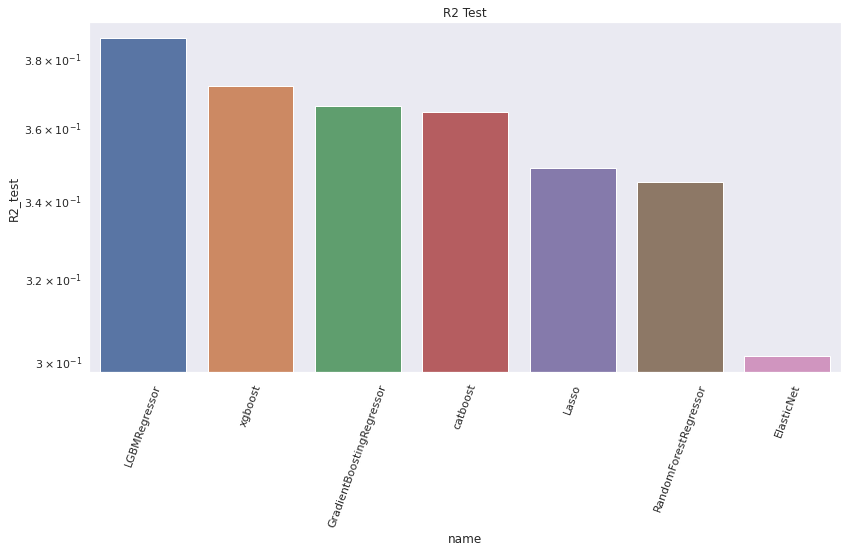

In [24]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
g = sns.barplot(x='name', y='R2_test', 
            data=ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0].sort_values('R2_test', ascending=False),
            ax=ax
           )
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=70)
ax.set_title('R2 Test')
plt.show()

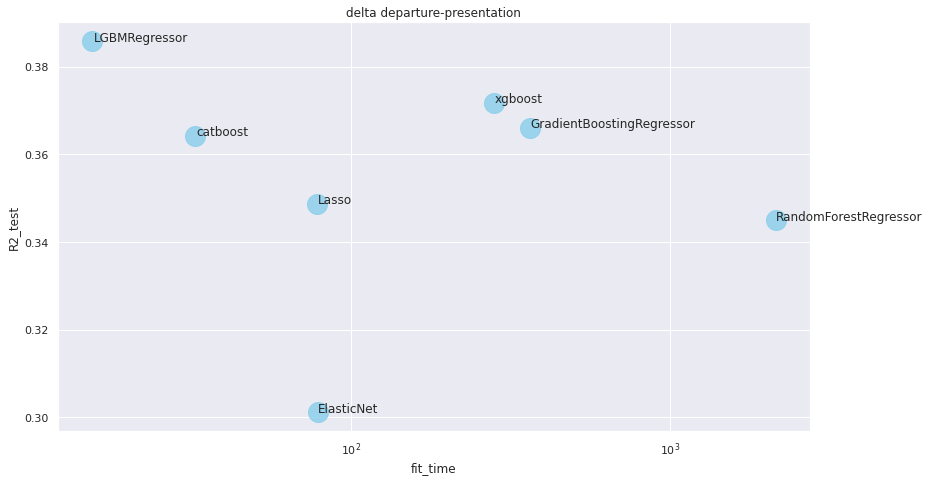

In [25]:
# basic plot
df = ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0]
plt.figure(figsize=(12,7))
ax = plt.subplot(111)
p1=sns.regplot(data=df, 
               x="fit_time", y="R2_test", 
               fit_reg=False, marker="o", 
               color="skyblue", scatter_kws={'s':400},
               ax=ax,
               )
ax.set_xscale('log')
ax.set_title(y_name)
# add annotations one by one with a loop
for line in range(0, df.shape[0]):
  p1.text(
      df.fit_time.iloc[line]+0.2, 
      df.R2_test.iloc[line], 
      df.name.iloc[line], 
      )

In [26]:
ALL_RESULTS_Y1 = ALL_RESULTS

## Runs all models for Y0

In [27]:
%%time
y_name = Y_NAMES[0]

try:ALL_RESULTS
except NameError: ALL_RESULTS=[]
#SAVE_RESULTS_TO_FILE = 'LOGS/Compare_ALL_RESULTS{:02d}.pickle'
i=0
for name, model in models_to_run.items():
    if any([(r.name == name) & (r.y_name==y_name) for r in ALL_RESULTS]):
        print(f'--- {name} for {y_name} already done')
        continue
    print('<<< Start ', name, 
          datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    try:
        _, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name=name,
            model=model,
            x_train=x_train_sp_1hot, 
            y_train=y_train_sp[y_name],
            x_test=x_test_sp_1hot, 
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )
        ALL_RESULTS_DF.to_csv('LOGS/Compare_ALL_RESULTS_DF.Y0.csv')
        #pickle.dump(ALL_RESULTS, open(SAVE_RESULTS_TO_FILE.format(i), 'wb'))
        print('R2_test', ALL_RESULTS[-1].R2_test)
    except Exception as ex:
        print('!!! {} has failed:'.format(name), ex)
        # raise ex
    finally:
      print(i, '>>> End of {}'.format(name), 
            datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    i += 1

<<< Start  LinearRegression 2020-09-12 18:56:08
R2_test -36175.67585401327
0 >>> End of LinearRegression 2020-09-12 18:56:44
<<< Start  Lasso 2020-09-12 18:56:44
R2_test 0.08649910044503606
1 >>> End of Lasso 2020-09-12 18:58:13
<<< Start  ElasticNet 2020-09-12 18:58:13
R2_test 0.05278793259721071
2 >>> End of ElasticNet 2020-09-12 18:59:22
<<< Start  DecisionTreeClassifier 2020-09-12 18:59:22
R2_test -0.34736660886456017
3 >>> End of DecisionTreeClassifier 2020-09-12 19:03:52
<<< Start  RandomForestRegressor 2020-09-12 19:03:52
R2_test 0.1516643680739701
4 >>> End of RandomForestRegressor 2020-09-12 19:43:13
<<< Start  GradientBoostingRegressor 2020-09-12 19:43:13
R2_test 0.1239867740759214
5 >>> End of GradientBoostingRegressor 2020-09-12 19:49:31
<<< Start  xgboost 2020-09-12 19:49:31
[19:49:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2_test 0.1527711309980716
6 >>> End of xgboost 2020-09-12 19:54:21
<<< St

In [28]:
ALL_RESULTS_DF.sort_values('R2_test', ascending=False)

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
7,LGBMRegressor,delta departure-presentation,3.402136e+04,0.506784,3.402136e+04,0.385874,15.366785,"LGBMRegressor(boosting_type='gbdt', class_weig..."
6,xgboost,delta departure-presentation,3.479908e+04,0.464300,3.479908e+04,0.371835,280.305879,"XGBRegressor(base_score=0.5, booster='gbtree',..."
5,GradientBoostingRegressor,delta departure-presentation,3.511775e+04,0.495268,3.511775e+04,0.366083,364.436944,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."
8,catboost,delta departure-presentation,3.521822e+04,0.496765,3.521822e+04,0.364269,32.355883,<catboost.core.CatBoostRegressor object at 0x7...
1,Lasso,delta departure-presentation,3.607889e+04,0.363949,3.607889e+04,0.348733,78.065768,"(RobustScaler(copy=True, quantile_range=(25.0,..."
4,RandomForestRegressor,delta departure-presentation,3.628378e+04,0.914137,3.628378e+04,0.345034,2142.523813,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."
2,ElasticNet,delta departure-presentation,3.871577e+04,0.321248,3.871577e+04,0.301134,78.308978,"(RobustScaler(copy=True, quantile_range=(25.0,..."
17,LGBMRegressor,delta selection-departure,4.894406e+03,0.420197,4.894406e+03,0.190204,14.827670,"LGBMRegressor(boosting_type='gbdt', class_weig..."
16,xgboost,delta selection-departure,5.120650e+03,0.546730,5.120650e+03,0.152771,277.206977,"XGBRegressor(base_score=0.5, booster='gbtree',..."
14,RandomForestRegressor,delta selection-departure,5.127339e+03,0.853497,5.127339e+03,0.151664,2334.248379,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."


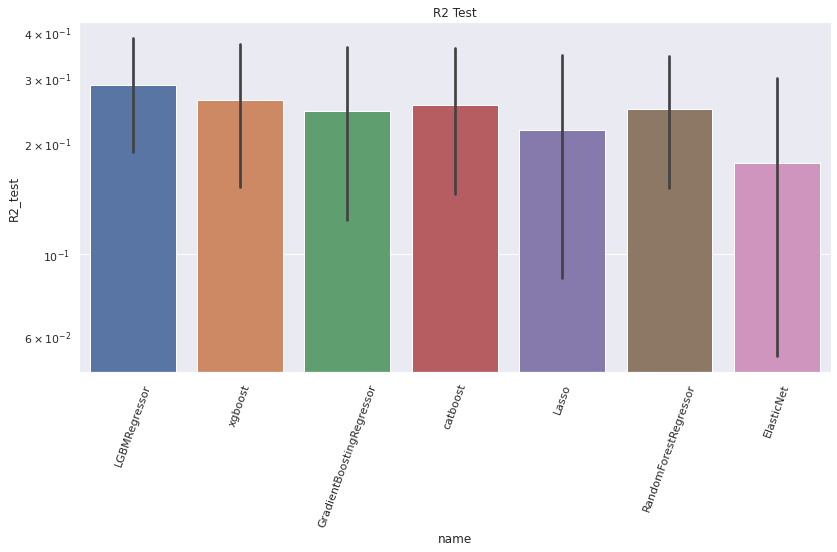

In [29]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
g = sns.barplot(x='name', y='R2_test', 
            data=ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0].sort_values('R2_test', ascending=False),
            ax=ax
           )
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=70)
ax.set_title('R2 Test')
plt.show()

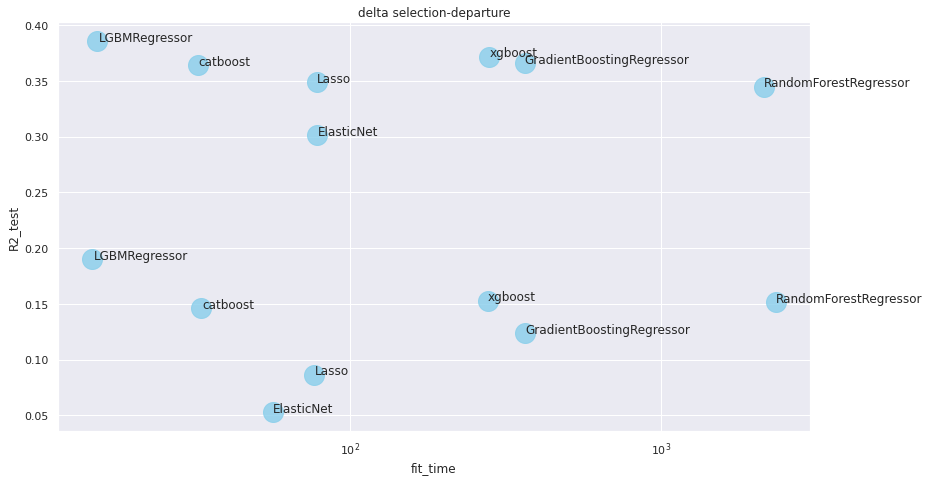

In [30]:
# basic plot
df = ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0]
plt.figure(figsize=(12,7))
ax = plt.subplot(111)
p1=sns.regplot(data=df, 
               x="fit_time", y="R2_test", 
               fit_reg=False, marker="o", 
               color="skyblue", scatter_kws={'s':400},
               ax=ax,
               )
ax.set_title(y_name)
ax.set_xscale('log')
# add annotations one by one with a loop
for line in range(0, df.shape[0]):
  p1.text(
      df.fit_time.iloc[line]+0.2, 
      df.R2_test.iloc[line], 
      df.name.iloc[line], 
      )

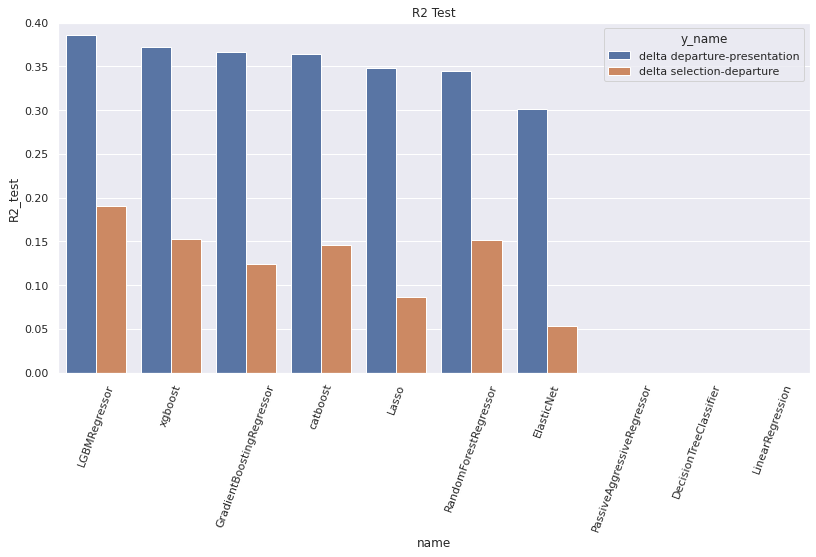

In [31]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
g = sns.barplot(
    x='name', 
    y='R2_test', 
    hue='y_name',
    #data=ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0].sort_values('R2_test', ascending=False),
    data=ALL_RESULTS_DF.sort_values('R2_test', ascending=False),
    ax=ax
    )
#ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=70)
ax.set_ylim(0.0, 0.4)
ax.set_title('R2 Test')
plt.show()

# Reload results

In [32]:
# ALL_RESULTS_DF = pd.read_csv('LOGS/Compare_ALL_RESULTS_DF.Y0.csv')
# ALL_RESULTS_DF.sort_values(['y_name', 'R2_test'], ascending=False)

In [33]:
Y_NAMES = ['delta selection-departure',
 'delta departure-presentation',
 'delta selection-presentation']

In [34]:
df

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
1,Lasso,delta departure-presentation,36078.890329,0.363949,36078.890329,0.348733,78.065768,"(RobustScaler(copy=True, quantile_range=(25.0,..."
2,ElasticNet,delta departure-presentation,38715.766213,0.321248,38715.766213,0.301134,78.308978,"(RobustScaler(copy=True, quantile_range=(25.0,..."
4,RandomForestRegressor,delta departure-presentation,36283.780378,0.914137,36283.780378,0.345034,2142.523813,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."
5,GradientBoostingRegressor,delta departure-presentation,35117.749934,0.495268,35117.749934,0.366083,364.436944,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."
6,xgboost,delta departure-presentation,34799.075912,0.464300,34799.075912,0.371835,280.305879,"XGBRegressor(base_score=0.5, booster='gbtree',..."
7,LGBMRegressor,delta departure-presentation,34021.359034,0.506784,34021.359034,0.385874,15.366785,"LGBMRegressor(boosting_type='gbdt', class_weig..."
8,catboost,delta departure-presentation,35218.216503,0.496765,35218.216503,0.364269,32.355883,<catboost.core.CatBoostRegressor object at 0x7...
11,Lasso,delta selection-departure,5521.197599,0.106125,5521.197599,0.086499,76.596957,"(RobustScaler(copy=True, quantile_range=(25.0,..."
12,ElasticNet,delta selection-departure,5724.947829,0.059342,5724.947829,0.052788,56.373001,"(RobustScaler(copy=True, quantile_range=(25.0,..."
14,RandomForestRegressor,delta selection-departure,5127.338852,0.853497,5127.338852,0.151664,2334.248379,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."


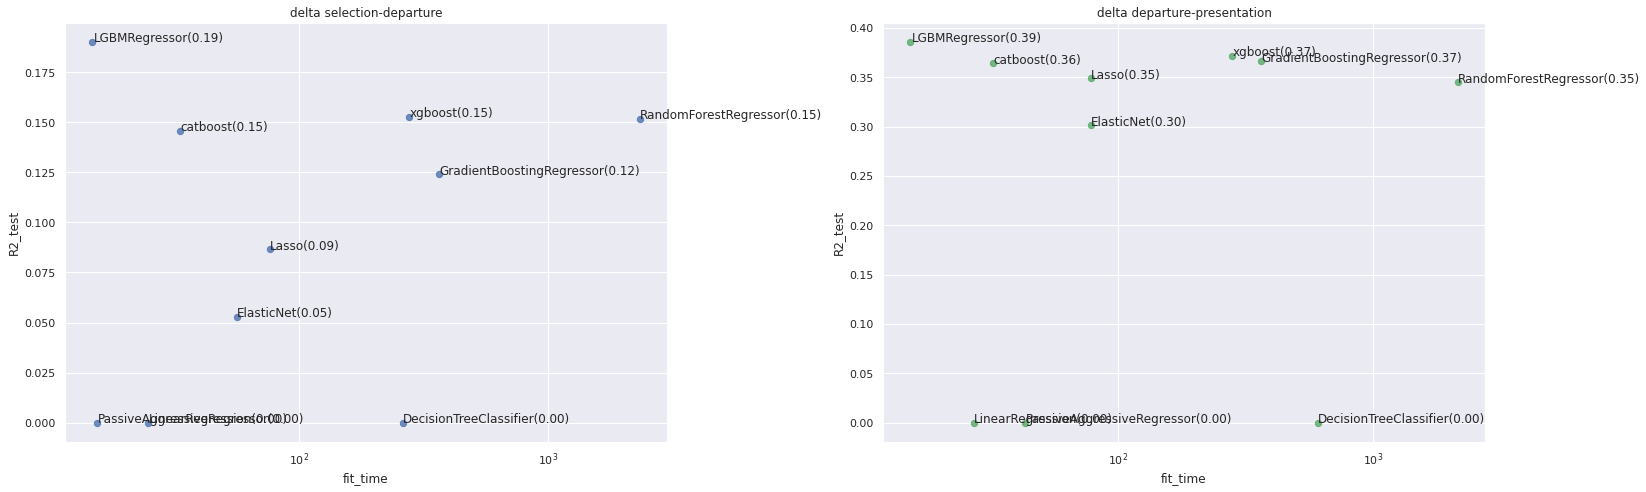

In [35]:
#df = ALL_RESULTS_DF[ALL_RESULTS_DF.R2_test >= 0]
df = ALL_RESULTS_DF.copy()
df['R2_test'].clip(lower=0, inplace=True)  # replace negative by 0

plt.figure(figsize=(23,7))
colors = {0: 'b', 1: 'g'}
for i, y_name in enumerate(Y_NAMES[:-1]):
  ax = plt.subplot(121+i)
  df2 = df[df.y_name==y_name]
  p1=sns.regplot(data=df2, 
                x="fit_time", y="R2_test", 
                fit_reg=False, marker="o", 
                color=colors[i], 
                scatter_kws={'s':40},
                ax=ax,
                )
  ax.set_title(y_name)
  ax.set_xscale('log')
  # ax.set_ylim(0.0, 0.2)
  # add annotations one by one with a loop
  for line in range(0, df2.shape[0]):
    ax.text(
        df2.fit_time.iloc[line]+0.2, 
        df2.R2_test.iloc[line], 
        f'{df2.name.iloc[line]}({df2.R2_test.iloc[line]:.02f})', 
        )

plt.tight_layout()